In [ ]:
# Reference: https://arxiv.org/pdf/2303.11570

In [1]:
import torch
import torchvision 
from torchvision import transforms
from torch import nn 

Datasets: CIFAR-10

# Boundary Shrink
Unlearning for image classification tasks
Reassign the labels of forget to nearby classes and finetune the model

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("CIFAR-10 dataset downloaded and loaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded and loaded successfully!


Files already downloaded and verified
Class: plane


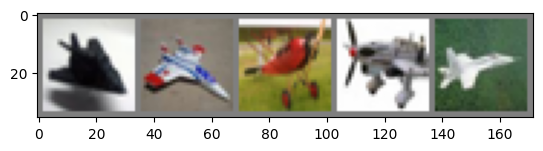

Class: car


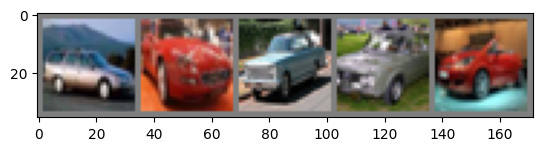

Class: bird


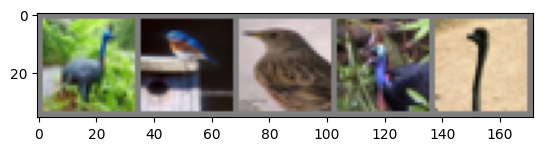

Class: cat


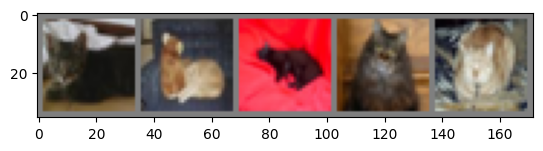

Class: deer


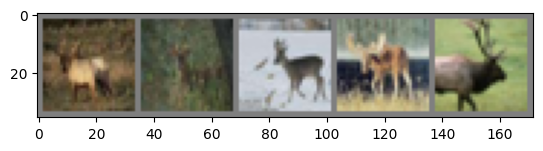

Class: dog


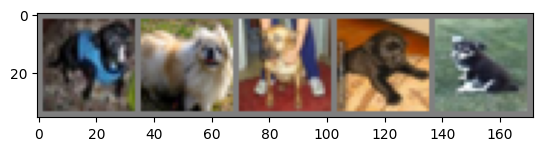

Class: frog


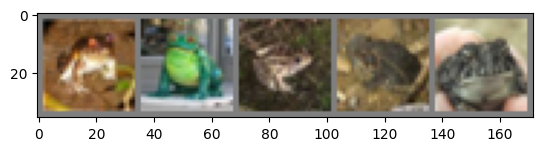

Class: horse


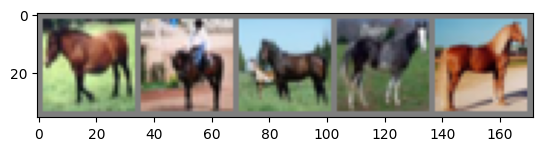

Class: ship


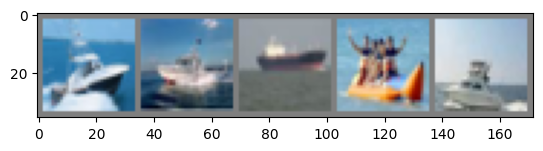

Class: truck


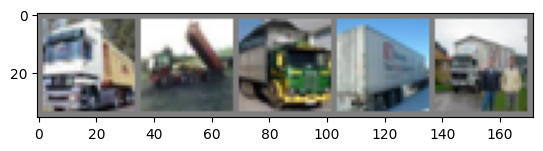

In [ ]:
#Visualize dataset
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get 5 images from each class
def get_images_by_class(dataset, num_images=5):
    class_images = {i: [] for i in range(10)}
    for img, label in dataset:
        if len(class_images[label]) < num_images:
            class_images[label].append(img)
        if all(len(images) == num_images for images in class_images.values()):
            break
    return class_images

# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
class_images = get_images_by_class(trainset)

# Visualize the images
for class_idx, images in class_images.items():
    print(f"Class: {classes[class_idx]}")
    imshow(torchvision.utils.make_grid(images))


In [3]:
forget_class = 5 # dog

In [4]:
from torch.utils.data import Subset
def filter_by_class(dataset, target_class):
    indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]
    return Subset(dataset, indices)

# Function to filter dataset excluding a specific class
def filter_excluding_class(dataset, target_class):
    indices = [i for i, (_, label) in enumerate(dataset) if label != target_class]
    return Subset(dataset, indices)

trainset_forget = filter_by_class(trainset, forget_class)
trainset_retain = filter_excluding_class(trainset, forget_class)
testset_forget = filter_by_class(testset, forget_class)
testset_retain = filter_excluding_class(testset, forget_class)

# Create data loaders
trainloader_forget = torch.utils.data.DataLoader(trainset_forget, batch_size=64, shuffle=True, num_workers=2)
trainloader_retain = torch.utils.data.DataLoader(trainset_retain, batch_size=64, shuffle=True, num_workers=2)
testloader_forget = torch.utils.data.DataLoader(testset_forget, batch_size=64, shuffle=False, num_workers=2)
testloader_retain = torch.utils.data.DataLoader(testset_retain, batch_size=64, shuffle=False, num_workers=2)

In [7]:
import torch
import torch.nn.functional as F

def nbi(dataset, model, criterion, epsilon=1):
    '''
    Find nearest but correct label for data points 

    parameters:
        dataset: data points to relabel
        model: trained model on full dataset
        criterion: loss function
    
    output:
        a relabelled dataset
    '''
    relabelled_dataset = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for x, y in dataset:
        x = x.to(device).clone().detach().requires_grad_(True)  # Ensure x requires gradient
        current_label = torch.tensor([y], device=device)
        
        while True:
            output = model(x)
            loss = criterion(output, current_label)
            loss.backward()
            
            if x.grad is None:
                raise RuntimeError("Gradient for x is None. Ensure x is involved in the computation of the loss.")
            
            with torch.no_grad():
                x += epsilon * x.grad.sign()  # Update x using the gradient
                x.grad.zero_()  # Reset gradients for the next iteration
            
            probabilities = F.softmax(model(x), dim=1)
            new_label = probabilities.argmax(dim=1).item()
            
            if new_label != current_label.item():
                relabelled_dataset.append((x.detach().cpu(), new_label))
                break
    
    return relabelled_dataset


CNN model
Trained on full dataset

In [8]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model
def train_model(trainloader, model, criterion, optimizer, model_name, num_epochs=30):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 200 == 199:  # Print every 200 mini-batches
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
                running_loss = 0.0

    print('Finished Training')
    torch.save(model.state_dict(), f'{model_name}.pth')

Using device: cuda


In [14]:
# Testing the model
def test_model(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on test images: {100 * correct / total:.2f}%')

In [ ]:
# Train the target model
train_model(trainloader, model, criterion, optimizer, "cnn_cifar10")

# Save the trained model

print('Model saved!')



# Test the target model
test_model(testloader, model)


In [ ]:
# retrained model 
train_model(trainloader_retain, model, criterion, optimizer, "retrained_cifar10")

In [59]:
relabelled_trainset_forget = nbi(trainset_forget, model, criterion)

In [ ]:
for (original_data, original_label), (new_data, new_label) in zip(trainset_forget, relabelled_trainset_forget):
    if original_label != new_label:
        print(f"Original label: {original_label}, New label: {new_label}")
    else:
        print(f"Label unchanged: {original_label}")


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

data = torch.stack([item[0] for item in relabelled_trainset_forget])
labels = torch.tensor([item[1] for item in relabelled_trainset_forget])

train_unlearn_dataset = TensorDataset(data, labels)
train_unlearn_loader = DataLoader(train_unlearn_dataset, batch_size=32, shuffle=True)

num_epochs=30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_unlearn_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_unlearn_loader)}')

torch.save(model.state_dict(), 'unlearn_cifar10.pth')

In [65]:
test_model(testloader_forget, model)

Accuracy of the network on the 10000 test images: 0.00%


In [67]:
test_model(testloader, model)

Accuracy of the network on the 10000 test images: 46.02%


In [9]:
model = CNN().to(device)
model.load_state_dict(torch.load('unlearn_cifar10.pth'))
test_model(testloader_retain, model)

C:\Users\HARSHA N P\AppData\Local\Temp\ipykernel_6656\1770203392.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unlearn_cifar10.pth'))

Accuracy of the network on the 10000 test images: 50.46%


In [12]:
print(len(testset_forget))
print(len(testset_retain))

1000
9000


In [11]:
model = CNN().to(device)
model.load_state_dict(torch.load('retrained_cifar10.pth'))
test_model(testloader_retain, model)

C:\Users\HARSHA N P\AppData\Local\Temp\ipykernel_16544\1834851321.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('retrained_cifar10.pth

Accuracy of the network on the 10000 test images: 75.03%
